# Modelling using value of R0

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [1420]:
import pandas as pd, numpy as np, time
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
import shap
%matplotlib inline

#### Auxiliary Functions

##### highlight_min()
Highlights minimum values for every dataframe column

In [1421]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
def plot_aux_dist():
    
    y_test_pred = y_pred
    y_train_pred = y_pred_train

    test = y_test
    train = y_train

    res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
    res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
    res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
    res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

    res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
    res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
    res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
    res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
    plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
    plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
    plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
    fig.tight_layout()

## Read file and prepare data 

In [1422]:
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL.csv')
del df['Unnamed: 0']
del df['Excess mortality P-scores, all ages']
del df['Excess mortality P-scores, all ages Prev 7 days']
del df['Excess mortality P-scores, all ages Prev 35 days']
del df['deaths']
del df['deaths_prev_28']
del df['deaths_prev_35']
del df['month']
del df['population']
del df['life_expectancy']
del df['UN Population Division (Median Age) (2017)']

In [1423]:
df.head()

,Code,Date,contact_tracing,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,...,urban_population,total_vaccinations_per_100,%youth_unemployment_total,%df_population_gr_65,"Excess mortality P-scores, all ages Prev 28 days",average_deaths_2015_2019_all_ages,deaths_prev_7,accumulated,R0_prev28,R0
0,AUS,2020-03-08,2.0,1.050000,1.722333,-0.739000,4.977667,-2.089000,7.927667,0.0,...,85.904,NaN,11.84,15.921202,4.42,3126.25,153.811500,0.000545,1.331325,0.949187
1,AUS,2020-03-15,2.0,0.761714,1.510143,-1.286000,7.697286,-0.819857,10.567714,0.0,...,85.904,NaN,11.84,15.921202,6.18,3126.25,145.995875,0.001306,1.398190,0.989293
2,AUS,2020-03-22,2.0,1.285714,3.367429,-1.081714,9.346857,0.938857,10.877857,0.0,...,85.904,NaN,11.84,15.921202,4.53,3126.25,144.432750,0.001865,0.733010,1.575758
3,AUS,2020-03-29,2.0,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,0.0,...,85.904,NaN,11.84,15.921202,4.92,3126.25,227.591000,0.002471,1.086093,1.666209
4,AUS,2020-04-05,2.0,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,0.0,...,85.904,NaN,11.84,15.921202,4.67,2564.75,311.104175,0.002943,0.949187,0.932399


### Data fitering on R0 extreme and abnormal values
* R0 is calculated as the division of deaths/deaths_prev_7
* Secondly we remove R0 values smaller than 0 and higher than 8.9 from our dataset. 
It is recorded that R0 in coronavirus ranges from 3.8 to 7 therefore it doesn´t make sense to include values higher than 7 because if any value higher than 7 is recorded it might be due to errors in the data.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7657547/

In [1424]:
df=df[~df.isin([np.inf, -np.inf]).any(1)]
df['limit']=5*df['average_deaths_2015_2019_all_ages']/100
df=df[(df['deaths_prev_7']>=df['limit']) & (np.abs(df['R0'])<=7) & (df['R0']>0)]
del df['average_deaths_2015_2019_all_ages']
del df['deaths_prev_7']
del df['limit']
df.sort_values('R0')
df_pca=df.copy()

Text(0.5, 1.0, 'R0')

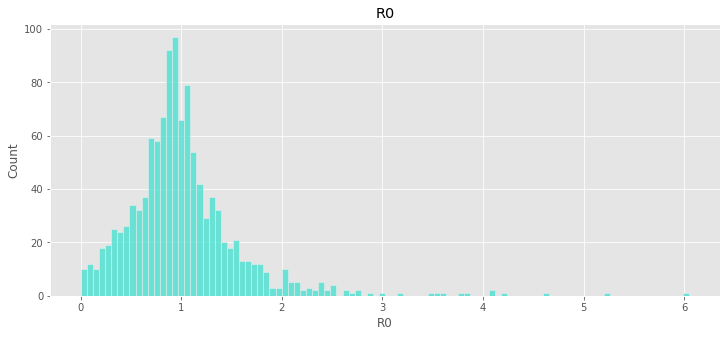

In [1425]:
#Removing -inf and infinite
df=df[~df.isin([np.inf, -np.inf]).any(1)]
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes, color='turquoise');
axes.set_title('R0')

## Feature Engineering

### Approach 1: Raw data no grouping of variables or PCA Analysis
Train models with raw data, no previous transformation or grouping done

In [1426]:
df_appch1=df[['Code', 'Date','contact_tracing', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'doctors_per_1000', 'nurses_per_1000',
       'beds_per_1000', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', '%youth_unemployment_total',
       '%df_population_gr_65', 'accumulated', 'R0_prev28', 'R0']]

### Approach 2: Grouping variables, decreasing dimensionality and correlation
Since variables seem to have high multicollinearity will group variables with similar corellation

In [1427]:
#We define bad mobility as the weighted average of mobility trends that have a positive impact on covid spread
df_appch2=df.copy()
df_appch2['bad_mobility']=(df_appch2['retail_and_recreation']*0.4+df_appch2['transit_stations']*0.2
                           +df_appch2['grocery_and_pharmacy']*0.2+df_appch2['workplaces']*0.2)
del df_appch2['retail_and_recreation']
del df_appch2['grocery_and_pharmacy']
del df_appch2['transit_stations']
del df_appch2['workplaces']

#We define good mobility as the weighted average of mobility trends that have a negative impact on covid spread
df_appch2['good_mobility']=(df_appch2['residential']*0.6+df_appch2['parks']*0.4)
del df_appch2['residential']
del df_appch2['parks']


df_appch2['tourism']=df_appch2['number_of_arrivals']*(4-df_appch2['international_travel_controls'])
df_appch2['awareness'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8
df_appch2['work_life_closures']=df_appch2['workplace_closures']*0.7+df_appch2['school_closures']*0.3
df_appch2['government_support']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['%df_population_gr_65']=df_appch2['%df_population_gr_65']-(df_appch2['accumulated']*df_appch2['%df_population_gr_65']/100)
df_appch2['nurses_per_1000']=df_appch2.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 28 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 28 days']), axis=1)
df_appch2['doctors_per_1000']=df_appch2.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 28 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 28 days']), axis=1)
df_appch2['beds_per_1000']=df_appch2.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 28 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 28 days']), axis=1)
df_appch2['hospital_availability']=df_appch2['nurses_per_1000']*0.2+df_appch2['doctors_per_1000']*0.2+df_appch2['beds_per_1000']*0.6
df_appch2['youth_effect']=df_appch2['%youth_unemployment_total']*df_appch2['bad_mobility']

del df_appch2['contact_tracing']
del df_appch2['testing_policy']
del df_appch2['international_travel_controls']
del df_appch2['number_of_arrivals']
del df_appch2['public_information_campaigns']
del df_appch2['facial_coverings']
del df_appch2['workplace_closures']
del df_appch2['school_closures']
del df_appch2['debt_relief']
del df_appch2['income_support']
del df_appch2['doctors_per_1000']
del df_appch2['beds_per_1000']
del df_appch2['nurses_per_1000']
del df_appch2['%youth_unemployment_total']
del df_appch2['urban_population']
del df_appch2['%df_population_gr_65']

df_appch2=df_appch2[[c for c in df_appch2 if c not in ['R0']] 
       + ['R0']]

In [1428]:
df_appch2.head()

,Code,Date,restrictions_internal_movements,close_public_transport,stay_home_requirements,restriction_gatherings,cancel_public_events,Holiday,temp,prcp,...,R0_prev28,bad_mobility,good_mobility,tourism,awareness,work_life_closures,government_support,hospital_availability,youth_effect,R0
3,AUS,2020-03-29,0.0,0.0,0.000000,0.000000,0.000000,0.0,21.346512,0.142010,...,1.086093,4.836771,-1.375400,8.263000e+06,0.4,0.000000,0.000000,-21.31696,57.267374,1.666209
4,AUS,2020-04-05,0.0,0.0,0.000000,0.857143,0.571429,0.0,21.176835,0.054789,...,0.949187,3.853000,-1.714343,8.263000e+06,0.4,0.000000,0.500000,-19.95746,45.619521,0.932399
5,AUS,2020-04-12,2.0,0.0,0.285714,2.285714,2.000000,0.0,20.702945,0.051898,...,0.989293,-4.383686,-2.873400,1.180429e+06,0.4,0.857143,0.642857,-19.68556,-51.902840,0.562334
6,AUS,2020-04-19,2.0,0.0,1.000000,3.571429,2.000000,0.0,21.093375,0.073336,...,1.575758,-27.187829,-3.216429,0.000000e+00,0.4,2.300000,1.500000,-34.15064,-321.903894,0.463836
8,AUS,2020-05-03,2.0,0.0,2.000000,4.000000,2.000000,2.0,19.355421,0.060733,...,0.932399,-42.469343,-3.355114,0.000000e+00,0.4,2.300000,1.500000,-56.06578,-502.837026,0.553043


### Approach 3: PCA
Since variables have a high correlation we will group variables taking use of Principal Component Analysis

In [1429]:
df_appch3=df.copy()
del df_appch3['doctors_per_1000']
del df_appch3['nurses_per_1000']
del df_appch3['beds_per_1000']
del df_appch3['number_of_arrivals']

df_appch3['total_vaccinations_per_100'] = df_appch3['total_vaccinations_per_100'].fillna(0)
df_appch3['accumulated'] = df_appch3['accumulated'].fillna(0)
df_appch3['urban_population'] = df_appch3['urban_population'].fillna(df_appch3['urban_population'].mean())
df_appch3['parks'] = df_appch3['parks'].fillna(df_appch3['parks'].mean())
df_appch3['temp'] = df_appch3['temp'].fillna(df_appch3['temp'].mean())
df_appch3['prcp'] = df_appch3['prcp'].fillna(df_appch3['prcp'].mean())
df_appch3['%youth_unemployment_total'] = df_appch3['%youth_unemployment_total'].fillna(df_appch3['%youth_unemployment_total'].mean())
df_appch3['%df_population_gr_65'] = df_appch3['%df_population_gr_65'].fillna(df_appch3['%df_population_gr_65'].mean())
#Just one null value
df_appch3['R0_prev28'] = df_appch3['R0_prev28'].fillna(df_appch3['R0_prev28'].mean())

In [1430]:
df_appch3.isna().sum()

Code                                                0
Date                                                0
contact_tracing                                     0
retail_and_recreation                               0
grocery_and_pharmacy                                0
residential                                         0
transit_stations                                    0
parks                                               0
workplaces                                          0
debt_relief                                         0
income_support                                      0
testing_policy                                      0
international_travel_controls                       0
restrictions_internal_movements                     0
close_public_transport                              0
public_information_campaigns                        0
facial_coverings                                    0
stay_home_requirements                              0
restriction_gatherings      

In [1431]:
features=['contact_tracing',
       'retail_and_recreation', 'grocery_and_pharmacy', 'residential',
       'transit_stations', 'parks', 'workplaces', 'debt_relief',
       'income_support', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'urban_population',
       'total_vaccinations_per_100', '%youth_unemployment_total',
       '%df_population_gr_65','accumulated', 'R0_prev28']

# Separating out the features
x = df_appch3.reindex(columns = features).values
# Separating out the target
y = df_appch3.reindex(columns = ['R0']).values
# Standardizing the features
x = StandardScaler().fit_transform(x)

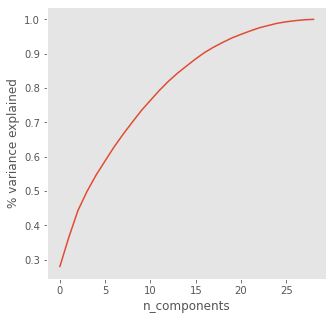

In [1432]:
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [1433]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
#Include Date and R0 for later filtering
principalDf['Date']=df_appch3['Date']
principalDf['R0']=df_appch3['R0']
df_appch3=principalDf

# Modelling and Evaluation

#### Approach 1: Raw data no grouping of variables or PCA Analysis Split

In [1434]:
date=pd.Timestamp(2021, 2, 15)
X_1=df_appch1[(pd.to_datetime(df_appch1['Date']) <= date)]
X_2=df_appch1[(pd.to_datetime(df_appch1['Date']) > date)]
X_train_appch1=X_1[X_1.columns[2:-1]]
X_test_appch1=X_2[X_2.columns[2:-1]]
y_train_appch1=X_1['R0']
y_test_appch1=X_2['R0']

####  Approach 2: Grouping variables, decreasing dimensionality and correlation Split

In [1435]:
date=pd.Timestamp(2021, 2, 15)
X_1=df_appch2[(pd.to_datetime(df_appch2['Date']) <= date)]
X_2=df_appch2[(pd.to_datetime(df_appch2['Date']) > date)]
X_train_appch2=X_1[X_1.columns[2:-1]]
X_test_appch2=X_2[X_2.columns[2:-1]]
y_train_appch2=X_1['R0']
y_test_appch2=X_2['R0']

#### Approach 3: PCA  Split

In [1436]:
date=pd.Timestamp(2021, 2, 15)
X_1=df_appch3[(pd.to_datetime(df_appch3['Date']) <= date)]
X_2=df_appch3[(pd.to_datetime(df_appch3['Date']) > date)]
X_train_appch3=X_1[X_1.columns[0:-2]]
X_test_appch3=X_2[X_2.columns[0:-2]]
y_train_appch3=X_1['R0']
y_test_appch3=X_2['R0']

#### Check best parameters for our trees to avoid overfitting

Initial approach on max depth and n_trees

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   11.1s


Best: -0.407922 using {'max_depth': 2, 'n_estimators': 50}
-0.407922 (0.036225) with: {'max_depth': 2, 'n_estimators': 50}
-0.425104 (0.032816) with: {'max_depth': 2, 'n_estimators': 100}
-0.438198 (0.030558) with: {'max_depth': 2, 'n_estimators': 150}
-0.451348 (0.030030) with: {'max_depth': 2, 'n_estimators': 200}
-0.413992 (0.031961) with: {'max_depth': 4, 'n_estimators': 50}
-0.429689 (0.028875) with: {'max_depth': 4, 'n_estimators': 100}
-0.432644 (0.028104) with: {'max_depth': 4, 'n_estimators': 150}
-0.434294 (0.027399) with: {'max_depth': 4, 'n_estimators': 200}
-0.426309 (0.047146) with: {'max_depth': 6, 'n_estimators': 50}
-0.429920 (0.046635) with: {'max_depth': 6, 'n_estimators': 100}
-0.430753 (0.047033) with: {'max_depth': 6, 'n_estimators': 150}
-0.430859 (0.046919) with: {'max_depth': 6, 'n_estimators': 200}
-0.425281 (0.047922) with: {'max_depth': 8, 'n_estimators': 50}
-0.425860 (0.048436) with: {'max_depth': 8, 'n_estimators': 100}
-0.425878 (0.048449) with: {'max_de

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.9s finished


Text(0, 0.5, 'Negative - MAE')

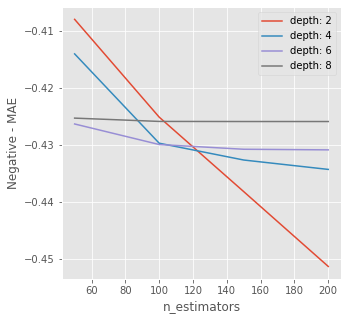

In [1377]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]

model = XGBRegressor() 

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

grid_result = grid_search.fit(X_train_appch1, y_train_appch1)

# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Negative - MAE')

As seen, best range of estimators seems to be [100, 120] with a max_depth in range [4,6], other combinations may end up with bad results or overfitting

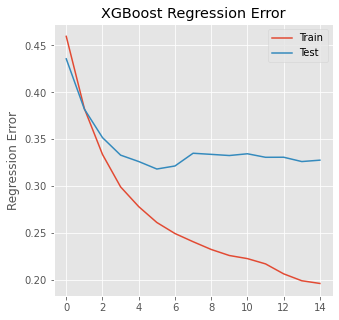

In [1378]:
#Default is created with max_depth 6 and n_estimators 100 which is correct for the following analysis
model = XGBRegressor()

eval_set = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]

model.fit(X_train_appch1, y_train_appch1, eval_metric=["mae"], eval_set=eval_set, verbose=False, early_stopping_rounds=10)
results = model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('XGBoost Regression Error')
pyplot.show()

## XGBoost Regressor 

### Modelling
We will model with the restriction observed in the previous section analyzing posible tuning in the parameters for Grid Search CV, for each of the three different approaches

In [1437]:
# A parameter grid for XGBoost
fit_params1={'n_estimators':[100,110,120],'max_depth' : [6,7,8]}
fit_params2={'n_estimators':[100,110,120],'max_depth' : [6,7,8]}
fit_params3={'n_estimators':[100,110,120],'max_depth' : [6,7,8]}

# Initialize XGB and GridSearch
xgb = XGBRegressor() 

grid1 = GridSearchCV(xgb, fit_params1, verbose=0, n_jobs=-1, scoring='neg_mean_absolute_error')
grid2 = GridSearchCV(xgb, fit_params2, verbose=0, n_jobs=-1,  scoring='neg_mean_absolute_error')
grid3 = GridSearchCV(xgb, fit_params3, verbose=0, n_jobs=-1,  scoring='neg_mean_absolute_error')

In [1438]:
%%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, early_stopping_rounds=3, verbose=False)
grid2.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, early_stopping_rounds=3, verbose=False)
grid3.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, early_stopping_rounds=3, verbose=False)

CPU times: user 951 ms, sys: 49.5 ms, total: 1 s
Wall time: 3.58 s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [1439]:
y_pred_1=grid1.best_estimator_.predict(X_test_appch1)
y_pred_train_1=grid1.best_estimator_.predict(X_train_appch1)
y_pred_2=grid2.best_estimator_.predict(X_test_appch2)
y_pred_train_2=grid2.best_estimator_.predict(X_train_appch2)
y_pred_3=grid3.best_estimator_.predict(X_test_appch3)
y_pred_train_3=grid3.best_estimator_.predict(X_train_appch3)

### XGB Evaluation

#### Test Set

In [1440]:
mae_1 = mean_absolute_error(y_test_appch1, y_pred_1)
mse_1 = mean_squared_error(y_test_appch1, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test_appch1, y_pred_1))
r2_1 = r2_score(y_test_appch1, y_pred_1)
mape_1 = np.mean(np.abs((y_test_appch1 - y_pred_1) / y_test_appch1)) * 100

mae_2 = mean_absolute_error(y_test_appch2, y_pred_2)
mse_2 = mean_squared_error(y_test_appch2, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_appch2, y_pred_2))
r2_2 = r2_score(y_test_appch2, y_pred_2)
mape_2 = np.mean(np.abs((y_test_appch2 - y_pred_2) / y_test_appch2)) * 100

mae_3 = mean_absolute_error(y_test_appch3, y_pred_3)
mse_3 = mean_squared_error(y_test_appch3, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test_appch3, y_pred_3))
r2_3 = r2_score(y_test_appch3, y_pred_3)
mape_3 = np.mean(np.abs((y_test_appch3 - y_pred_3) / y_test_appch3)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1': r2_1, 'Approach 2': r2_2, 'Approach 3': r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3} }
    
df_scores_xgb=pd.DataFrame(scores)
df_scores_xgb.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.314482,0.173401,0.416414,-0.005519,49.901330
Approach 2,0.278670,0.133070,0.364787,0.228351,45.197637
Approach 3,0.273553,0.138023,0.371514,0.173301,35.461761


#### Train Set

In [1441]:
mae_1 = mean_absolute_error(y_train_appch1, y_pred_train_1)
mse_1 = mean_squared_error(y_train_appch1, y_pred_train_1)
rmse_1 = np.sqrt(mean_squared_error(y_train_appch1, y_pred_train_1))
r2_1 = r2_score(y_train_appch1, y_pred_train_1)
mape_1 = np.mean(np.abs((y_train_appch1 - y_pred_train_1) / y_train_appch1)) * 100

mae_2 = mean_absolute_error(y_train_appch2, y_pred_train_2)
mse_2 = mean_squared_error(y_train_appch2, y_pred_train_2)
rmse_2 = np.sqrt(mean_squared_error(y_train_appch2, y_pred_train_2))
r2_2 = r2_score(y_train_appch2, y_pred_train_2)
mape_2 = np.mean(np.abs((y_train_appch2 - y_pred_train_2) / y_train_appch2)) * 100

mae_3 = mean_absolute_error(y_train_appch3, y_pred_train_3)
mse_3 = mean_squared_error(y_train_appch3, y_pred_train_3)
rmse_3 = np.sqrt(mean_squared_error(y_train_appch3, y_pred_train_3))
r2_3 = r2_score(y_train_appch3, y_pred_train_3)
mape_3 = np.mean(np.abs((y_train_appch3 - y_pred_train_3) / y_train_appch3)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1': r2_1, 'Approach 2': r2_2, 'Approach 3': r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3} }
    
df_scores_xgb_train=pd.DataFrame(scores)
df_scores_xgb_train.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.235287,0.120410,0.347001,0.644322,74.243269
Approach 2,0.216025,0.094801,0.307898,0.719967,69.553925
Approach 3,0.170731,0.059550,0.244029,0.823966,46.923408


## Results View

#### Actual vs Predicted

Text(0.5, 1.0, 'Train Set Approach 3')

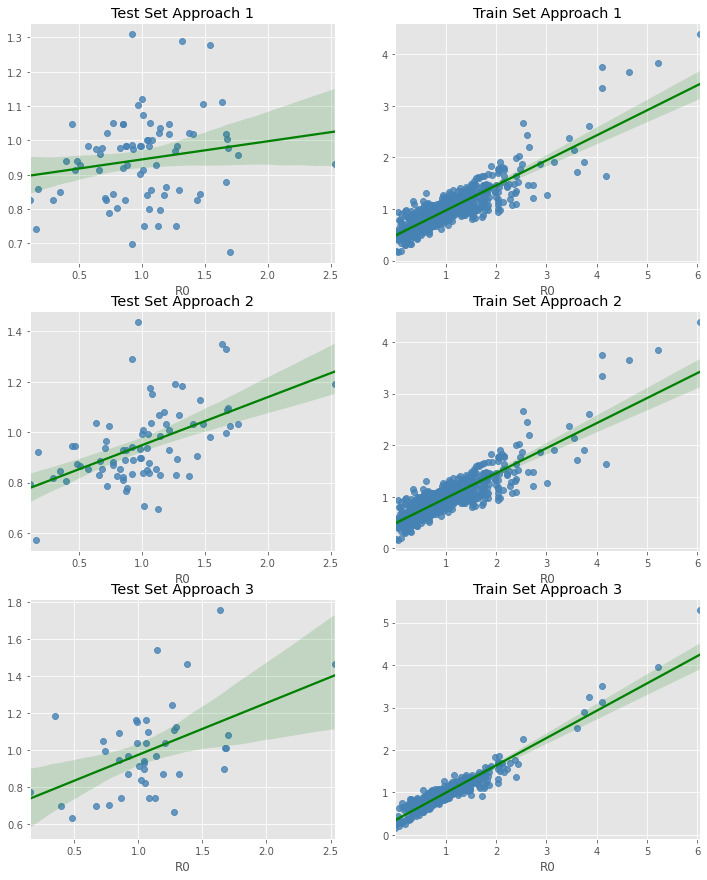

In [1442]:
fig, axes = plt.subplots(3,2, figsize=(12,15))


sns.regplot(y_test_appch1,y_pred_1,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[0][0]) \
            .set_title('Actual vs Predicted')
sns.regplot(y_train_appch1,y_pred_train_1,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[0][1]) \
            .set_title('Actual vs Predicted')

axes[0][0].set_title('Test Set Approach 1')
axes[0][1].set_title('Train Set Approach 1')

sns.regplot(y_test_appch2,y_pred_2,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[1][0]) \
            .set_title('Actual vs Predicted')
sns.regplot(y_train_appch1,y_pred_train_1,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[1][1]) \
            .set_title('Actual vs Predicted')

axes[1][0].set_title('Test Set Approach 2')
axes[1][1].set_title('Train Set Approach 2')

sns.regplot(y_test_appch3,y_pred_3,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[2][0]) \
            .set_title('Actual vs Predicted')
sns.regplot(y_train_appch3,y_pred_train_3,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[2][1]) \
            .set_title('Actual vs Predicted')

axes[2][0].set_title('Test Set Approach 3')
axes[2][1].set_title('Train Set Approach 3')

In [1454]:
def plot_aux(approach, y_test, y_pred, y_train, y_pred_train, ax):
    ax[approach][0].scatter(y_test, y_pred, color='mediumseagreen')
    ax[approach][0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][0].set_title('Test Set Approach' + str(approach+1))
    ax[approach][0].set_xlabel('Measured')
    ax[approach][0].set_ylabel('Predicted')
    
    ax[approach][1].scatter(y_train, y_pred_train, color='cornflowerblue')
    ax[approach][1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][1].set_xlabel('Measured')
    ax[approach][1].set_ylabel('Predicted')
    ax[approach][1].set_title('Train Set Approach' + str(approach+1))

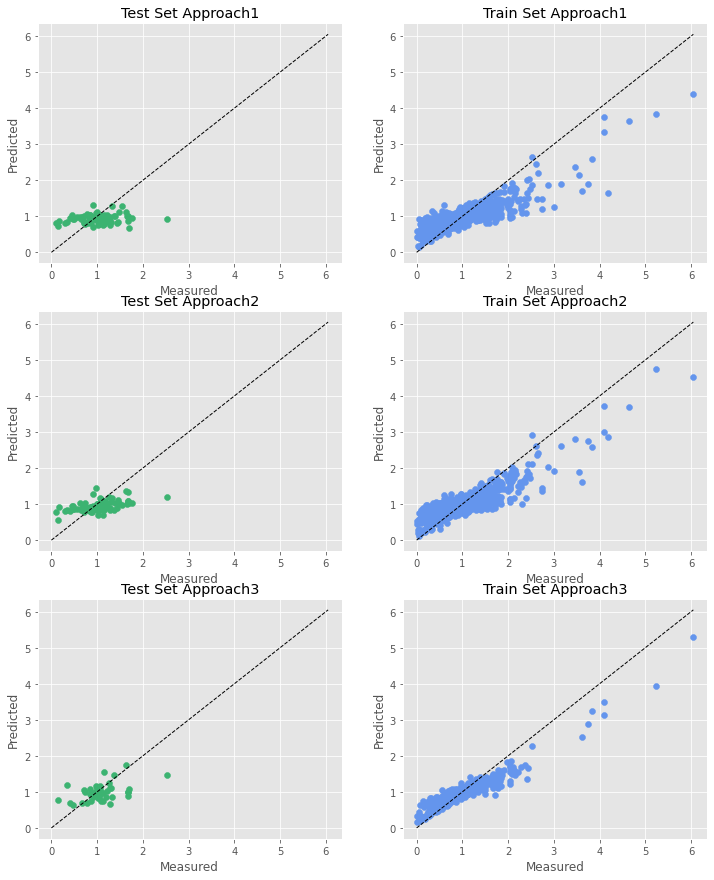

In [1455]:
fig, ax = plt.subplots(3,2,figsize=(12,15))

plot_aux(0, y_test_appch1, y_pred_1, y_train_appch1, y_pred_train_1, ax)
plot_aux(1, y_test_appch2, y_pred_2, y_train_appch2, y_pred_train_2, ax)
plot_aux(2, y_test_appch3, y_pred_3, y_train_appch3, y_pred_train_3, ax)

plt.show()

## Light GBM

### Modelling 

In [581]:
params = {
    'metric': ['mape'],
    "max_depth":[6,7,8] , 
    "n_estimators":[150,180]
}

# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid = GridSearchCV(lgbm, params)

In [582]:
%%time
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
grid.fit(X_train, y_train)

CPU times: user 16.6 s, sys: 349 ms, total: 17 s
Wall time: 4.83 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_depth': [6, 7, 8], 'metric': ['mape'],
                         'n_estimators': [150, 180]})

In [583]:
grid.best_estimator_

LGBMRegressor(max_depth=7, metric='mape', n_estimators=150)

In [584]:
y_pred = grid.best_estimator_.predict(X_test)
y_pred_train = grid.best_estimator_.predict(X_train)

### Evaluation

#### Test Set

In [585]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse':rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.39301314506469553
mse score is 0.25144062967742753
rmse score is 0.5014385602219155
r2 score is -0.43134470593872054
mape score is 49.31997545229019


#### Train Set

In [586]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.17338669950805322
mse score is 0.07363737695387941
rmse score is 0.271362077221338
r2 score is 0.8170150174148214
mape score is 50.723253191845


In [587]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
100,0.736446,0.919688,0.183242
209,1.684699,0.763902,0.920797
210,1.667890,0.619944,1.047946
211,1.701320,0.694078,1.007242
212,1.634012,0.943913,0.690099
...,...,...,...
1799,1.217174,0.992328,0.224846
1800,0.924848,0.942747,0.017899
1852,0.110414,0.713974,0.603560
1960,0.768153,0.974391,0.206237


### XGB Evaluation

#### Test Set

In [841]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.4010607024491025
mse score is 0.3124191883460084
rmse score is 0.5589447095608012
r2 score is -2.5107108034530827
mape score is 41.08286747054778


#### Train Set

In [842]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.18449845250634128
mse score is 0.07055112611299799
rmse score is 0.2656146195392829
r2 score is 0.8244916547228565
mape score is 62.904494818004565


In [843]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval.head()

,Actual,Predicted,Difference
100,0.736446,1.842445,1.105999
210,1.667890,1.012699,0.655190
211,1.701320,0.992370,0.708951
212,1.634012,1.020498,0.613515
213,1.318757,1.104188,0.214569


## Results View

#### Predicted vs Actual R0 Distribution

Text(0.5, 1.0, 'R0 Actuals')

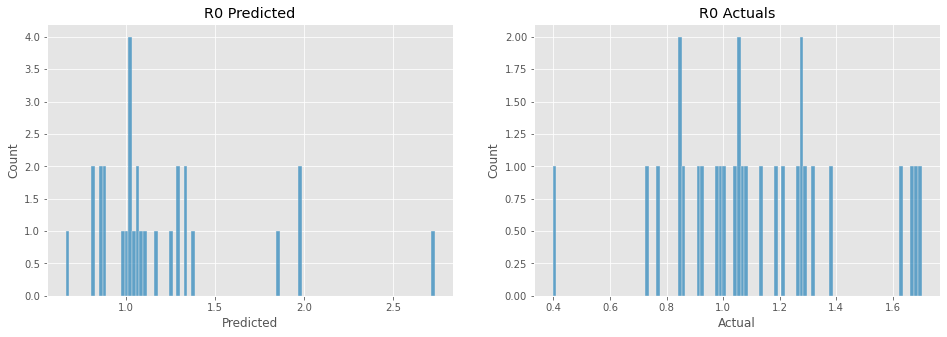

In [844]:
fig, axes =plt.subplots(1,2,figsize=(16,5))

sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes[0]);
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes[1]);
axes[0].set_title('R0 Predicted')
axes[1].set_title('R0 Actuals')

#### Difference Histogram 

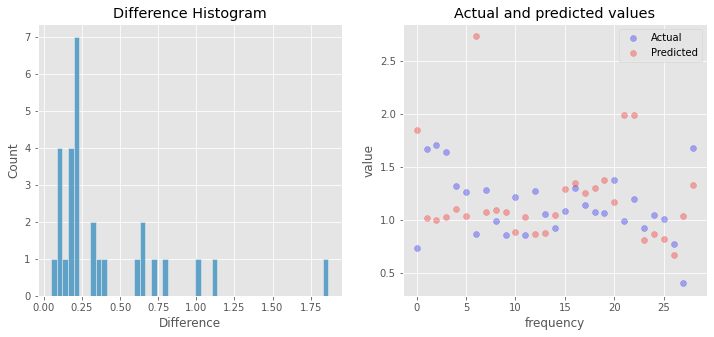

In [845]:
# plot difference hist
f, axes = plt.subplots(1,2, figsize=(12,5))

sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes[0]);
axes[0].set_title('Difference Histogram')

axes[1].scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
axes[1].scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)
plt.title('Actual and predicted values')
plt.xlabel('frequency')
plt.ylabel('value')
plt.legend()
plt.show()

#### Actual vs Predicted

Text(0.5, 1.0, 'Train Set')

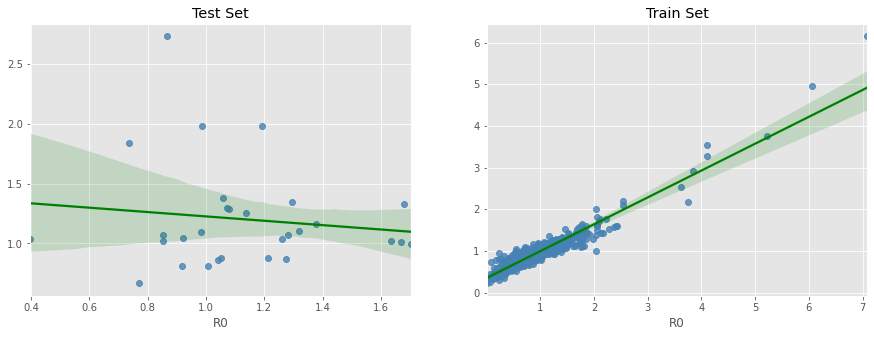

In [846]:
_, axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(y_test,y_pred,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[0]) \
            .set_title('Actual vs Predicted')
sns.regplot(y_train,y_pred_train,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "green"}, ax=axes[1]) \
            .set_title('Actual vs Predicted')
axes[0].set_title('Test Set')
axes[1].set_title('Train Set')

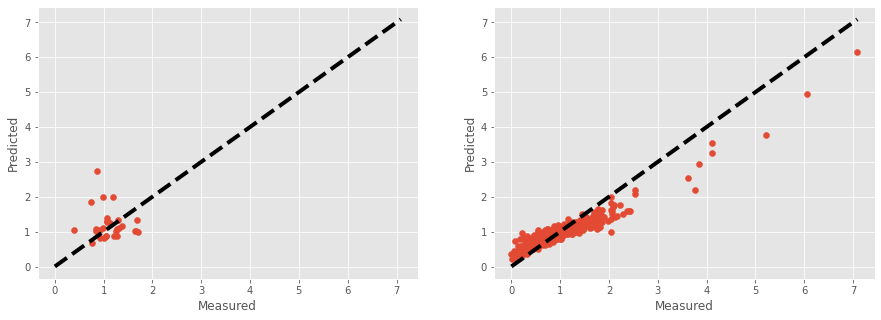

In [847]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(y_test, y_pred)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
axes[0].set_title('Train Set')
ax[0].set_xlabel('Measured')
ax[0].set_ylabel('Predicted')

ax[1].scatter(y_train, y_pred_train)
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax[1].set_xlabel('Measured')
ax[1].set_ylabel('Predicted')
axes[1].set_title('Test Set')

plt.show()

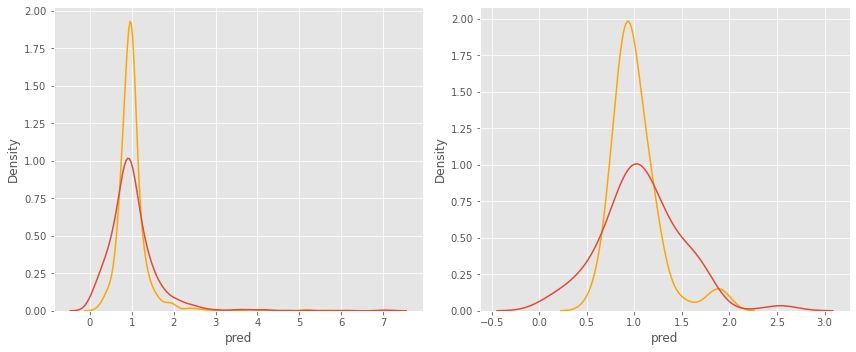

In [654]:
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

## CatBoost Regressor 

### Modelling 

In [617]:
ctbst = CatBoostRegressor(learning_rate=0.02, eval_metric='MAPE',depth=12, has_time=True)

ctbst.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)

0:	learn: 0.2959938	test: 0.2478719	best: 0.2478719 (0)	total: 163ms	remaining: 2m 42s
1:	learn: 0.2952529	test: 0.2480646	best: 0.2478719 (0)	total: 272ms	remaining: 2m 15s
2:	learn: 0.2944618	test: 0.2475096	best: 0.2475096 (2)	total: 386ms	remaining: 2m 8s
3:	learn: 0.2939949	test: 0.2471505	best: 0.2471505 (3)	total: 473ms	remaining: 1m 57s
4:	learn: 0.2937292	test: 0.2471765	best: 0.2471505 (3)	total: 482ms	remaining: 1m 35s
5:	learn: 0.2926437	test: 0.2466929	best: 0.2466929 (5)	total: 586ms	remaining: 1m 37s
6:	learn: 0.2914430	test: 0.2465189	best: 0.2465189 (6)	total: 717ms	remaining: 1m 41s
7:	learn: 0.2908913	test: 0.2462923	best: 0.2462923 (7)	total: 729ms	remaining: 1m 30s
8:	learn: 0.2903179	test: 0.2463214	best: 0.2462923 (7)	total: 858ms	remaining: 1m 34s
9:	learn: 0.2898285	test: 0.2462648	best: 0.2462648 (9)	total: 991ms	remaining: 1m 38s
10:	learn: 0.2886421	test: 0.2459328	best: 0.2459328 (10)	total: 1.14s	remaining: 1m 42s
11:	learn: 0.2878297	test: 0.2459747	best:

94:	learn: 0.2381789	test: 0.2475074	best: 0.2455413 (21)	total: 13s	remaining: 2m 3s
95:	learn: 0.2376035	test: 0.2474142	best: 0.2455413 (21)	total: 13.1s	remaining: 2m 3s
96:	learn: 0.2372467	test: 0.2474402	best: 0.2455413 (21)	total: 13.3s	remaining: 2m 3s
97:	learn: 0.2366606	test: 0.2476859	best: 0.2455413 (21)	total: 13.4s	remaining: 2m 3s
98:	learn: 0.2360558	test: 0.2479259	best: 0.2455413 (21)	total: 13.6s	remaining: 2m 3s
99:	learn: 0.2354403	test: 0.2482319	best: 0.2455413 (21)	total: 13.7s	remaining: 2m 3s
100:	learn: 0.2352016	test: 0.2481990	best: 0.2455413 (21)	total: 13.9s	remaining: 2m 3s
101:	learn: 0.2351007	test: 0.2480774	best: 0.2455413 (21)	total: 14s	remaining: 2m 3s
102:	learn: 0.2346082	test: 0.2475375	best: 0.2455413 (21)	total: 14.2s	remaining: 2m 3s
103:	learn: 0.2340896	test: 0.2475547	best: 0.2455413 (21)	total: 14.4s	remaining: 2m 3s
104:	learn: 0.2335459	test: 0.2480625	best: 0.2455413 (21)	total: 14.5s	remaining: 2m 3s
105:	learn: 0.2333094	test: 0.2

187:	learn: 0.1970371	test: 0.2491778	best: 0.2455413 (21)	total: 26s	remaining: 1m 52s
188:	learn: 0.1967333	test: 0.2491040	best: 0.2455413 (21)	total: 26.1s	remaining: 1m 52s
189:	learn: 0.1962505	test: 0.2491403	best: 0.2455413 (21)	total: 26.3s	remaining: 1m 51s
190:	learn: 0.1958566	test: 0.2492818	best: 0.2455413 (21)	total: 26.4s	remaining: 1m 51s
191:	learn: 0.1954797	test: 0.2495189	best: 0.2455413 (21)	total: 26.5s	remaining: 1m 51s
192:	learn: 0.1951893	test: 0.2492706	best: 0.2455413 (21)	total: 26.6s	remaining: 1m 51s
193:	learn: 0.1948767	test: 0.2488476	best: 0.2455413 (21)	total: 26.7s	remaining: 1m 50s
194:	learn: 0.1945097	test: 0.2489815	best: 0.2455413 (21)	total: 26.8s	remaining: 1m 50s
195:	learn: 0.1940737	test: 0.2488454	best: 0.2455413 (21)	total: 26.9s	remaining: 1m 50s
196:	learn: 0.1937748	test: 0.2490958	best: 0.2455413 (21)	total: 27s	remaining: 1m 50s
197:	learn: 0.1933194	test: 0.2492105	best: 0.2455413 (21)	total: 27.1s	remaining: 1m 49s
198:	learn: 0.

280:	learn: 0.1637269	test: 0.2526139	best: 0.2455413 (21)	total: 37.4s	remaining: 1m 35s
281:	learn: 0.1634936	test: 0.2526466	best: 0.2455413 (21)	total: 37.5s	remaining: 1m 35s
282:	learn: 0.1632084	test: 0.2527001	best: 0.2455413 (21)	total: 37.6s	remaining: 1m 35s
283:	learn: 0.1628835	test: 0.2527420	best: 0.2455413 (21)	total: 37.8s	remaining: 1m 35s
284:	learn: 0.1626128	test: 0.2527845	best: 0.2455413 (21)	total: 37.9s	remaining: 1m 35s
285:	learn: 0.1622361	test: 0.2528097	best: 0.2455413 (21)	total: 38s	remaining: 1m 34s
286:	learn: 0.1620167	test: 0.2530194	best: 0.2455413 (21)	total: 38.1s	remaining: 1m 34s
287:	learn: 0.1616220	test: 0.2529484	best: 0.2455413 (21)	total: 38.2s	remaining: 1m 34s
288:	learn: 0.1612466	test: 0.2528119	best: 0.2455413 (21)	total: 38.4s	remaining: 1m 34s
289:	learn: 0.1608986	test: 0.2529252	best: 0.2455413 (21)	total: 38.5s	remaining: 1m 34s
290:	learn: 0.1605070	test: 0.2529482	best: 0.2455413 (21)	total: 38.6s	remaining: 1m 34s
291:	learn: 

372:	learn: 0.1396898	test: 0.2552627	best: 0.2455413 (21)	total: 48.8s	remaining: 1m 22s
373:	learn: 0.1394336	test: 0.2552310	best: 0.2455413 (21)	total: 48.9s	remaining: 1m 21s
374:	learn: 0.1391881	test: 0.2552453	best: 0.2455413 (21)	total: 49s	remaining: 1m 21s
375:	learn: 0.1390003	test: 0.2552173	best: 0.2455413 (21)	total: 49.1s	remaining: 1m 21s
376:	learn: 0.1387598	test: 0.2553174	best: 0.2455413 (21)	total: 49.3s	remaining: 1m 21s
377:	learn: 0.1385362	test: 0.2554093	best: 0.2455413 (21)	total: 49.4s	remaining: 1m 21s
378:	learn: 0.1384172	test: 0.2554436	best: 0.2455413 (21)	total: 49.5s	remaining: 1m 21s
379:	learn: 0.1381140	test: 0.2553229	best: 0.2455413 (21)	total: 49.6s	remaining: 1m 20s
380:	learn: 0.1379449	test: 0.2553635	best: 0.2455413 (21)	total: 49.8s	remaining: 1m 20s
381:	learn: 0.1376763	test: 0.2557213	best: 0.2455413 (21)	total: 49.9s	remaining: 1m 20s
382:	learn: 0.1373491	test: 0.2558001	best: 0.2455413 (21)	total: 50.1s	remaining: 1m 20s
383:	learn: 

465:	learn: 0.1226943	test: 0.2593768	best: 0.2455413 (21)	total: 1m	remaining: 1m 8s
466:	learn: 0.1224369	test: 0.2594732	best: 0.2455413 (21)	total: 1m	remaining: 1m 8s
467:	learn: 0.1223726	test: 0.2594208	best: 0.2455413 (21)	total: 1m	remaining: 1m 8s
468:	learn: 0.1221160	test: 0.2595050	best: 0.2455413 (21)	total: 1m	remaining: 1m 8s
469:	learn: 0.1217789	test: 0.2593576	best: 0.2455413 (21)	total: 1m	remaining: 1m 8s
470:	learn: 0.1216258	test: 0.2593086	best: 0.2455413 (21)	total: 1m	remaining: 1m 8s
471:	learn: 0.1214820	test: 0.2593764	best: 0.2455413 (21)	total: 1m	remaining: 1m 8s
472:	learn: 0.1212930	test: 0.2593783	best: 0.2455413 (21)	total: 1m 1s	remaining: 1m 7s
473:	learn: 0.1210697	test: 0.2594123	best: 0.2455413 (21)	total: 1m 1s	remaining: 1m 7s
474:	learn: 0.1210089	test: 0.2594555	best: 0.2455413 (21)	total: 1m 1s	remaining: 1m 7s
475:	learn: 0.1209253	test: 0.2593795	best: 0.2455413 (21)	total: 1m 1s	remaining: 1m 7s
476:	learn: 0.1207609	test: 0.2594756	best

558:	learn: 0.1088517	test: 0.2616056	best: 0.2455413 (21)	total: 1m 11s	remaining: 56.6s
559:	learn: 0.1086927	test: 0.2616333	best: 0.2455413 (21)	total: 1m 11s	remaining: 56.4s
560:	learn: 0.1085346	test: 0.2617623	best: 0.2455413 (21)	total: 1m 11s	remaining: 56.3s
561:	learn: 0.1083869	test: 0.2617768	best: 0.2455413 (21)	total: 1m 12s	remaining: 56.2s
562:	learn: 0.1083013	test: 0.2619000	best: 0.2455413 (21)	total: 1m 12s	remaining: 56s
563:	learn: 0.1081950	test: 0.2620259	best: 0.2455413 (21)	total: 1m 12s	remaining: 55.9s
564:	learn: 0.1079664	test: 0.2621753	best: 0.2455413 (21)	total: 1m 12s	remaining: 55.8s
565:	learn: 0.1078628	test: 0.2620829	best: 0.2455413 (21)	total: 1m 12s	remaining: 55.6s
566:	learn: 0.1077647	test: 0.2620733	best: 0.2455413 (21)	total: 1m 12s	remaining: 55.5s
567:	learn: 0.1076674	test: 0.2623103	best: 0.2455413 (21)	total: 1m 12s	remaining: 55.4s
568:	learn: 0.1075601	test: 0.2626001	best: 0.2455413 (21)	total: 1m 12s	remaining: 55.3s
569:	learn: 

650:	learn: 0.0957189	test: 0.2627671	best: 0.2455413 (21)	total: 1m 23s	remaining: 44.7s
651:	learn: 0.0955715	test: 0.2627801	best: 0.2455413 (21)	total: 1m 23s	remaining: 44.5s
652:	learn: 0.0954576	test: 0.2627743	best: 0.2455413 (21)	total: 1m 23s	remaining: 44.4s
653:	learn: 0.0952974	test: 0.2627256	best: 0.2455413 (21)	total: 1m 23s	remaining: 44.3s
654:	learn: 0.0951204	test: 0.2627916	best: 0.2455413 (21)	total: 1m 23s	remaining: 44.1s
655:	learn: 0.0949540	test: 0.2627664	best: 0.2455413 (21)	total: 1m 23s	remaining: 44s
656:	learn: 0.0947490	test: 0.2627065	best: 0.2455413 (21)	total: 1m 24s	remaining: 43.9s
657:	learn: 0.0946005	test: 0.2626517	best: 0.2455413 (21)	total: 1m 24s	remaining: 43.7s
658:	learn: 0.0945296	test: 0.2626600	best: 0.2455413 (21)	total: 1m 24s	remaining: 43.6s
659:	learn: 0.0944641	test: 0.2628132	best: 0.2455413 (21)	total: 1m 24s	remaining: 43.5s
660:	learn: 0.0942659	test: 0.2627859	best: 0.2455413 (21)	total: 1m 24s	remaining: 43.3s
661:	learn: 

742:	learn: 0.0843969	test: 0.2640137	best: 0.2455413 (21)	total: 1m 34s	remaining: 32.8s
743:	learn: 0.0842969	test: 0.2640081	best: 0.2455413 (21)	total: 1m 34s	remaining: 32.7s
744:	learn: 0.0841949	test: 0.2639430	best: 0.2455413 (21)	total: 1m 35s	remaining: 32.5s
745:	learn: 0.0840140	test: 0.2639476	best: 0.2455413 (21)	total: 1m 35s	remaining: 32.4s
746:	learn: 0.0838708	test: 0.2639692	best: 0.2455413 (21)	total: 1m 35s	remaining: 32.3s
747:	learn: 0.0838669	test: 0.2640095	best: 0.2455413 (21)	total: 1m 35s	remaining: 32.1s
748:	learn: 0.0837022	test: 0.2640569	best: 0.2455413 (21)	total: 1m 35s	remaining: 32s
749:	learn: 0.0835515	test: 0.2640276	best: 0.2455413 (21)	total: 1m 35s	remaining: 31.9s
750:	learn: 0.0834278	test: 0.2641607	best: 0.2455413 (21)	total: 1m 35s	remaining: 31.7s
751:	learn: 0.0832362	test: 0.2641715	best: 0.2455413 (21)	total: 1m 35s	remaining: 31.6s
752:	learn: 0.0830934	test: 0.2641262	best: 0.2455413 (21)	total: 1m 35s	remaining: 31.5s
753:	learn: 

834:	learn: 0.0739075	test: 0.2649551	best: 0.2455413 (21)	total: 1m 47s	remaining: 21.2s
835:	learn: 0.0738190	test: 0.2649953	best: 0.2455413 (21)	total: 1m 47s	remaining: 21.1s
836:	learn: 0.0738153	test: 0.2650310	best: 0.2455413 (21)	total: 1m 47s	remaining: 21s
837:	learn: 0.0737229	test: 0.2650085	best: 0.2455413 (21)	total: 1m 47s	remaining: 20.8s
838:	learn: 0.0736493	test: 0.2650201	best: 0.2455413 (21)	total: 1m 47s	remaining: 20.7s
839:	learn: 0.0736042	test: 0.2649964	best: 0.2455413 (21)	total: 1m 48s	remaining: 20.6s
840:	learn: 0.0735167	test: 0.2650410	best: 0.2455413 (21)	total: 1m 48s	remaining: 20.5s
841:	learn: 0.0733462	test: 0.2651756	best: 0.2455413 (21)	total: 1m 48s	remaining: 20.3s
842:	learn: 0.0733057	test: 0.2651735	best: 0.2455413 (21)	total: 1m 48s	remaining: 20.2s
843:	learn: 0.0731212	test: 0.2651784	best: 0.2455413 (21)	total: 1m 48s	remaining: 20.1s
844:	learn: 0.0731036	test: 0.2651994	best: 0.2455413 (21)	total: 1m 48s	remaining: 19.9s
845:	learn: 

926:	learn: 0.0657571	test: 0.2657919	best: 0.2455413 (21)	total: 2m 5s	remaining: 9.91s
927:	learn: 0.0657283	test: 0.2658211	best: 0.2455413 (21)	total: 2m 6s	remaining: 9.78s
928:	learn: 0.0656730	test: 0.2658613	best: 0.2455413 (21)	total: 2m 6s	remaining: 9.67s
929:	learn: 0.0655678	test: 0.2659319	best: 0.2455413 (21)	total: 2m 7s	remaining: 9.56s
930:	learn: 0.0655122	test: 0.2659151	best: 0.2455413 (21)	total: 2m 7s	remaining: 9.45s
931:	learn: 0.0654027	test: 0.2659097	best: 0.2455413 (21)	total: 2m 7s	remaining: 9.33s
932:	learn: 0.0653017	test: 0.2658974	best: 0.2455413 (21)	total: 2m 8s	remaining: 9.2s
933:	learn: 0.0652816	test: 0.2658906	best: 0.2455413 (21)	total: 2m 8s	remaining: 9.07s
934:	learn: 0.0651753	test: 0.2658461	best: 0.2455413 (21)	total: 2m 8s	remaining: 8.93s
935:	learn: 0.0650647	test: 0.2660228	best: 0.2455413 (21)	total: 2m 8s	remaining: 8.79s
936:	learn: 0.0649612	test: 0.2660809	best: 0.2455413 (21)	total: 2m 8s	remaining: 8.66s
937:	learn: 0.0648505	

In [618]:
y_pred = ctbst.predict(X_test)
y_pred_train = ctbst.predict(X_train)

### Evaluation

#### Test Set

In [619]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.31394466957028394
mse score is 0.17905813929872325
rmse score is 0.42315261939248733
r2 score is -0.019301932504958597
mape score is 49.27198016724659


#### Train Set

In [620]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.3735350492206055
mse score is 0.3571859679179554
rmse score is 0.5976503726410245
r2 score is 0.11241178294450449
mape score is 131.30327827420618


In [621]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
100,0.736446,0.982032,0.245587
209,1.684699,1.005672,0.679026
210,1.667890,0.999494,0.668396
211,1.701320,0.993338,0.707982
212,1.634012,1.025256,0.608757
...,...,...,...
1799,1.217174,0.983919,0.233255
1800,0.924848,0.982392,0.057544
1852,0.110414,0.971420,0.861006
1960,0.768153,0.997063,0.228910


### Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

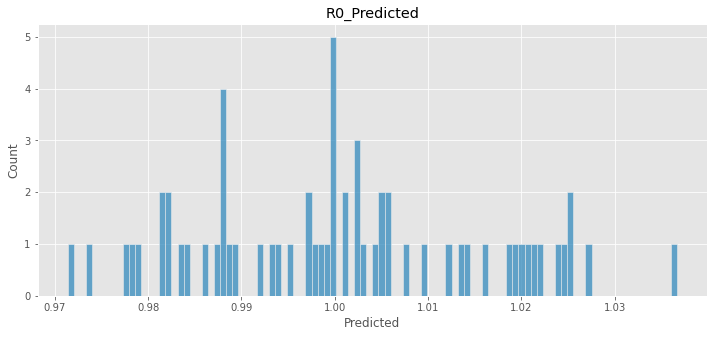

In [622]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

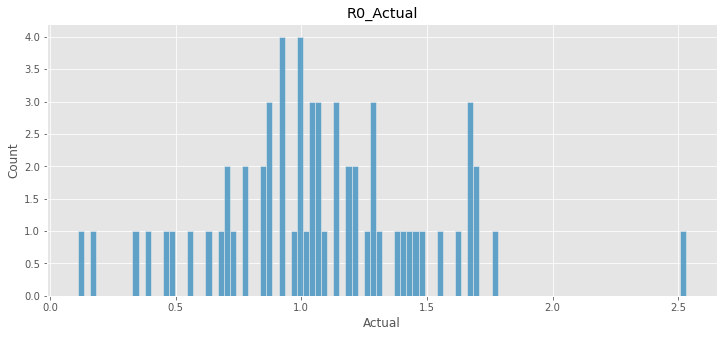

In [623]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

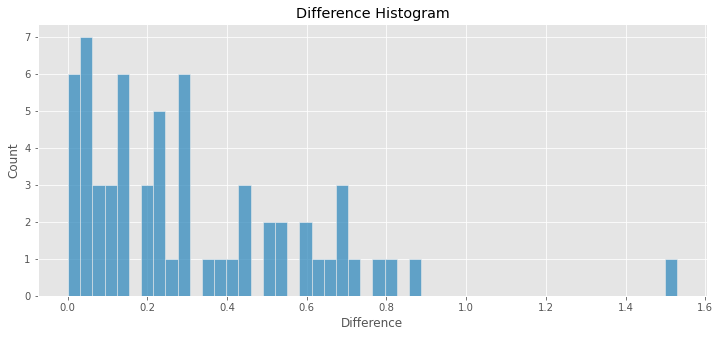

In [624]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

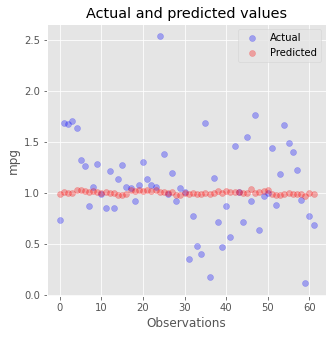

In [625]:
_, ax = plt.subplots(figsize=(5,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

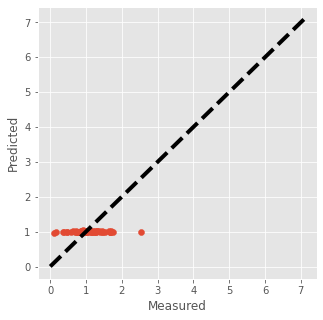

In [626]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

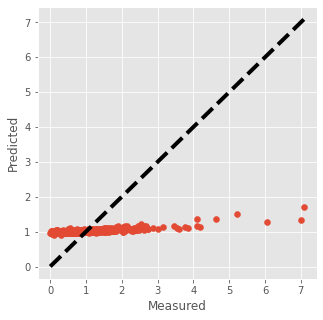

In [627]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

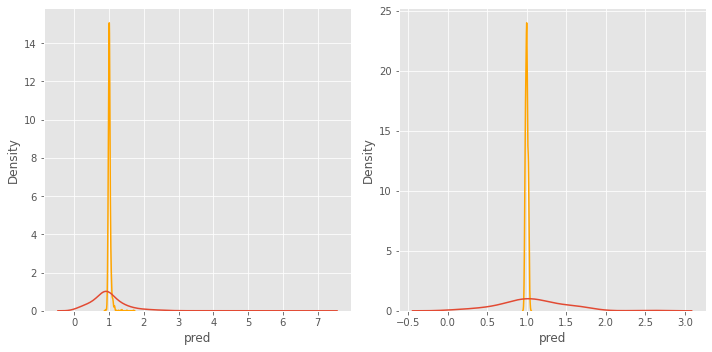

In [628]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [629]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
756,1.003141,2.531593,-1.53,1.53,-60.38
1738,0.995505,1.765018,-0.77,0.77,-43.60
211,0.993338,1.701320,-0.71,0.71,-41.61
1796,0.987995,1.664583,-0.68,0.68,-40.65
1136,0.999621,1.679276,-0.68,0.68,-40.47
...,...,...,...,...,...
1457,0.999684,0.469371,0.53,0.53,112.98
929,0.987151,0.397465,0.59,0.59,148.36
871,0.987984,0.347447,0.64,0.64,184.36
1188,0.988421,0.174586,0.81,0.81,466.15


In [630]:
df.columns

Index(['Code', 'Date', 'restrictions_internal_movements',
       'close_public_transport', 'stay_home_requirements',
       'restriction_gatherings', 'cancel_public_events', 'Holiday', 'temp',
       'prcp', 'total_vaccinations_per_100', 'accumulated', 'R0_prev28',
       'bad_mobility', 'good_mobility', 'tourism', 'awareness',
       'work_life_closures', 'government_support', 'hospital_availability',
       'youth_effect', 'R0'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

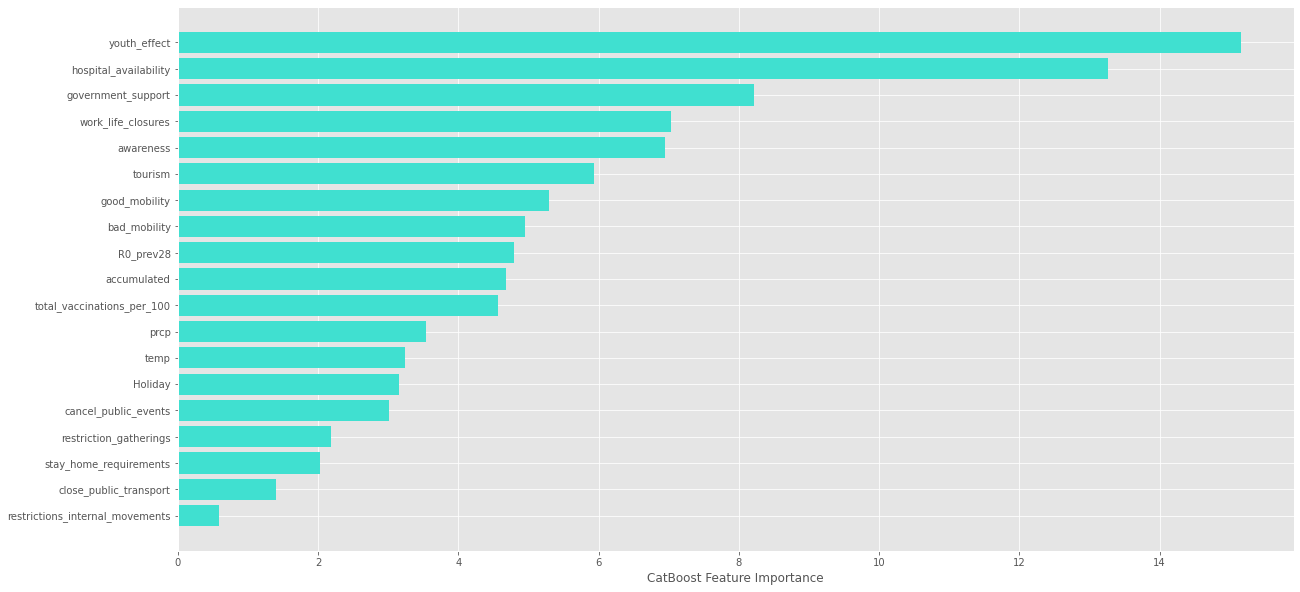

In [631]:
sorted_feature_importance = ctbst.feature_importances_.argsort()
plt.barh(df[df.columns[2:-1]].columns, 
        ctbst.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

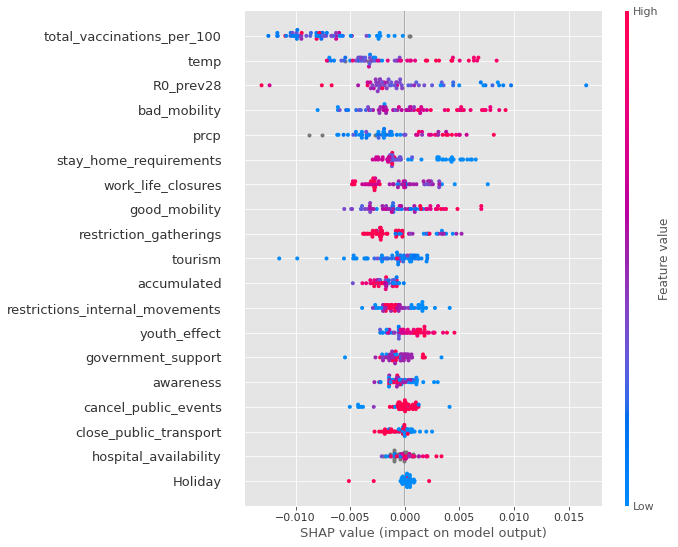

In [632]:
explainer = shap.TreeExplainer(ctbst)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = df[df.columns[2:-1]].columns)

## Cross Validation

In [702]:
aux=df.copy().reset_index()
aux=aux.sort_values('Date')
X=aux[aux.columns[3:-1]]
y=aux[aux.columns[-1]]

In [718]:
k = 10
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    grid.fit(X_train, y_train)
    pred_values = grid.best_estimator_.predict(X_test)
     
    acc = np.mean(np.abs((y_test - pred_values) / y_test)) * 100
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.2s finished


[10:59:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.0s finished


[10:59:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[10:59:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[10:59:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[10:59:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[10:59:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[10:59:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[10:59:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[10:59:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[10:59:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.8s finished


In [719]:
avg_acc_score

143.67324157434268

In [720]:
acc_score

[578.4285445482261,
 48.25562605425057,
 81.3240913154938,
 139.27250341326982,
 53.61068081165282,
 85.65969320344486,
 98.25137078935711,
 113.67544266570498,
 156.4900927646477,
 81.76437017737898]